In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tokenizer = AutoTokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl').to('cuda')

In [3]:
text = "Barack Obama was born in Honolulu, Hawaii. He was born in"
encoded_input = tokenizer(text, return_tensors='pt').to('cuda')
output = model(**encoded_input, output_hidden_states=True)

In [40]:
final_logit = output.logits.squeeze(0)[-1]
topk_values, topk_indices = torch.topk(F.softmax(final_logit, dim=0), k=5)

In [42]:
print('Top K tokens:\n')
for i in range(5):
    print(topk_values[i].item(), '\t', tokenizer.decode(topk_indices[i]))

Top K tokens:

0.2672717869281769 	  Hawaii
0.1756911426782608 	  the
0.1598847210407257 	  Honolulu
0.09687460958957672 	  1961
0.037270136177539825 	  Kenya


In [62]:
intermediate_probabilities = []

def intermediate_logits(x):
    return model.lm_head(model.transformer.ln_f(x))

for i in range(1, len(output.hidden_states) - 1):
    hidden_state = output.hidden_states[i].squeeze(0)[-1]
    hidden_logits = intermediate_logits(hidden_state)
    intermediate_probabilities.append(F.softmax(hidden_logits, dim=0)[topk_indices].tolist())

intermediate_probabilities.append(topk_values.tolist())
    
# Convert to numpy array for easier slicing
intermediate_probabilities_np = np.array(intermediate_probabilities)

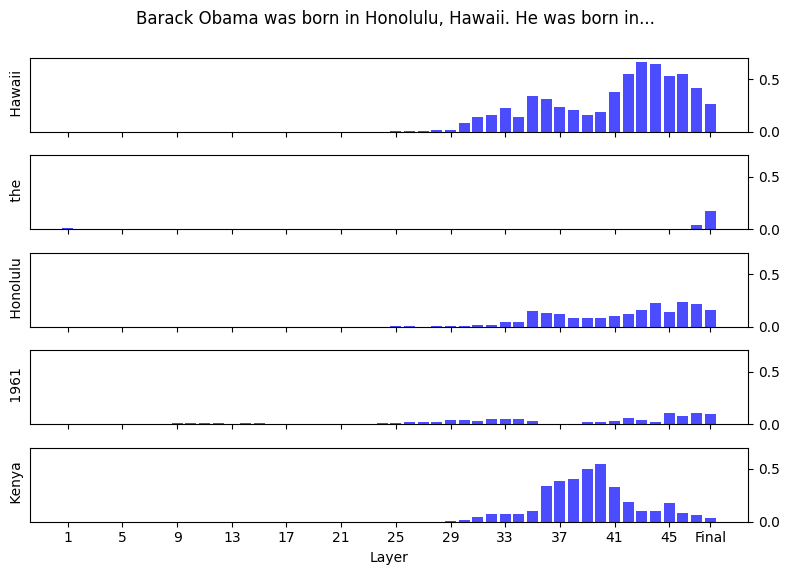

In [100]:
# Creating a plot with shared x-axis representing the dimension 48 and split y-axis for each of the 10 classes
fig, axs = plt.subplots(5, 1, figsize=(8, 6), sharex=True, sharey=True)

global_max = np.max(intermediate_probabilities_np)

# Each subplot represents one class (0-9)
for i in range(5):
    axs[i].bar(np.arange(48), intermediate_probabilities_np[:, i], color='b', alpha=0.7)
    axs[i].set_ylabel(tokenizer.decode(topk_indices[i]))
    axs[i].yaxis.tick_right()
    # axs[i].set_ylim(1e-3, global_max)  # Setting limits for log scale
    # axs[i].set_yscale('log')  # Setting y-axis to log scale

# Label the shared x-axis
axs[-1].set_xlabel('Layer')
axs[-1].set_xticks(np.append(np.arange(0, 48, 4), 47))
axs[-1].set_xticklabels([str(x+1) for x in np.arange(0, 48, 1) if x % 4 == 0] + ['Final'])

plt.suptitle("Barack Obama was born in Honolulu, Hawaii. He was born in...")
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()